In [159]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

import warnings

warnings.filterwarnings("ignore")

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [160]:
#import functions_20221007
import functions_20221010

In [161]:
runBad = False
if runBad:
    train_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
    test_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
    print(colored(f"Training data", "blue"), "-> ROWS:", train_data.shape[0], "COLUMNS:", train_data.shape[1])
    print(colored(f"Test data", "red"), "-> ROWS:", test_data.shape[0], "COLUMNS:", test_data.shape[1])
else:
    print(colored("abcde", "blue"))

abcde


In [162]:
LABEL = 'Price'

booleans = []
floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation']
categories = ['tenure.tenureType']

features = []
features.extend(booleans)
features.extend(floats)
features.extend(categories)
features.insert(0, LABEL)

print(colored(f"features", "blue"), "-> ", features)
#print(colored(f"Test data", "red"), "-> ROWS:", test_data.shape[0], "COLUMNS:", test_data.shape[1])

features ->  ['Price', 'location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation', 'tenure.tenureType']


In [163]:
def get_source_dataframe(folder_prefix='../'):
    #df = pd.read_csv(prefix + 'data/source/df_listings.csv', on_bad_lines='skip', index_col=0)
    df = functions_20221010.get_combined_dataset(HOW='inner', early_duplicates=True, folder_prefix=folder_prefix)
    return df

In [164]:
functions_20221010.set_csv_directory('final_split')
df_orig = get_source_dataframe(folder_prefix='../../')
print(len(df_orig))

54201


In [165]:
df = functions_20221010.pre_tidy_dataset(df_orig)

In [166]:
df = df[features]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54067 entries, 14520525 to 126181118
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               54067 non-null  float64
 1   location.latitude   54067 non-null  object 
 2   location.longitude  54067 non-null  float64
 3   bedrooms            52265 non-null  float64
 4   bathrooms           50569 non-null  float64
 5   nearestStation      54067 non-null  float64
 6   tenure.tenureType   50413 non-null  object 
dtypes: float64(5), object(2)
memory usage: 3.3+ MB


In [167]:
print(len(df_orig))
old_length = len(df_orig)

print(f"{old_length} ==> {len(df)}")
old_length = len(df)

54201
54201 ==> 54067


<div id = 3 style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#b08888;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
              color:white;
          text-align:center;
          margin:0 auto;
          ">
    ACTION - Force location.latitude to be a float, rather than a string
</h2>
</div>

In [168]:
df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)

print(f"{old_length} ==> {len(df)}")
old_length = len(df)

54067 ==> 54067


In [169]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,54067.0,416448.380528,113505.624206,100000.000000,325000.000000,425000.000000,500000.000000,600000.000000
location.latitude,54057.0,51.496130,0.076650,51.298317,51.439070,51.499478,51.554067,51.683185
location.longitude,54067.0,-0.106239,0.718769,-0.498315,-0.212965,-0.105220,-0.012998,51.558746
bedrooms,52265.0,11.360145,2143.329175,1.000000,1.000000,2.000000,2.000000,490000.000000
bathrooms,50569.0,1.181534,0.413244,1.000000,1.000000,1.000000,1.000000,12.000000
nearestStation,54067.0,0.442075,1.049040,0.000000,0.221778,0.361208,0.553963,192.431869


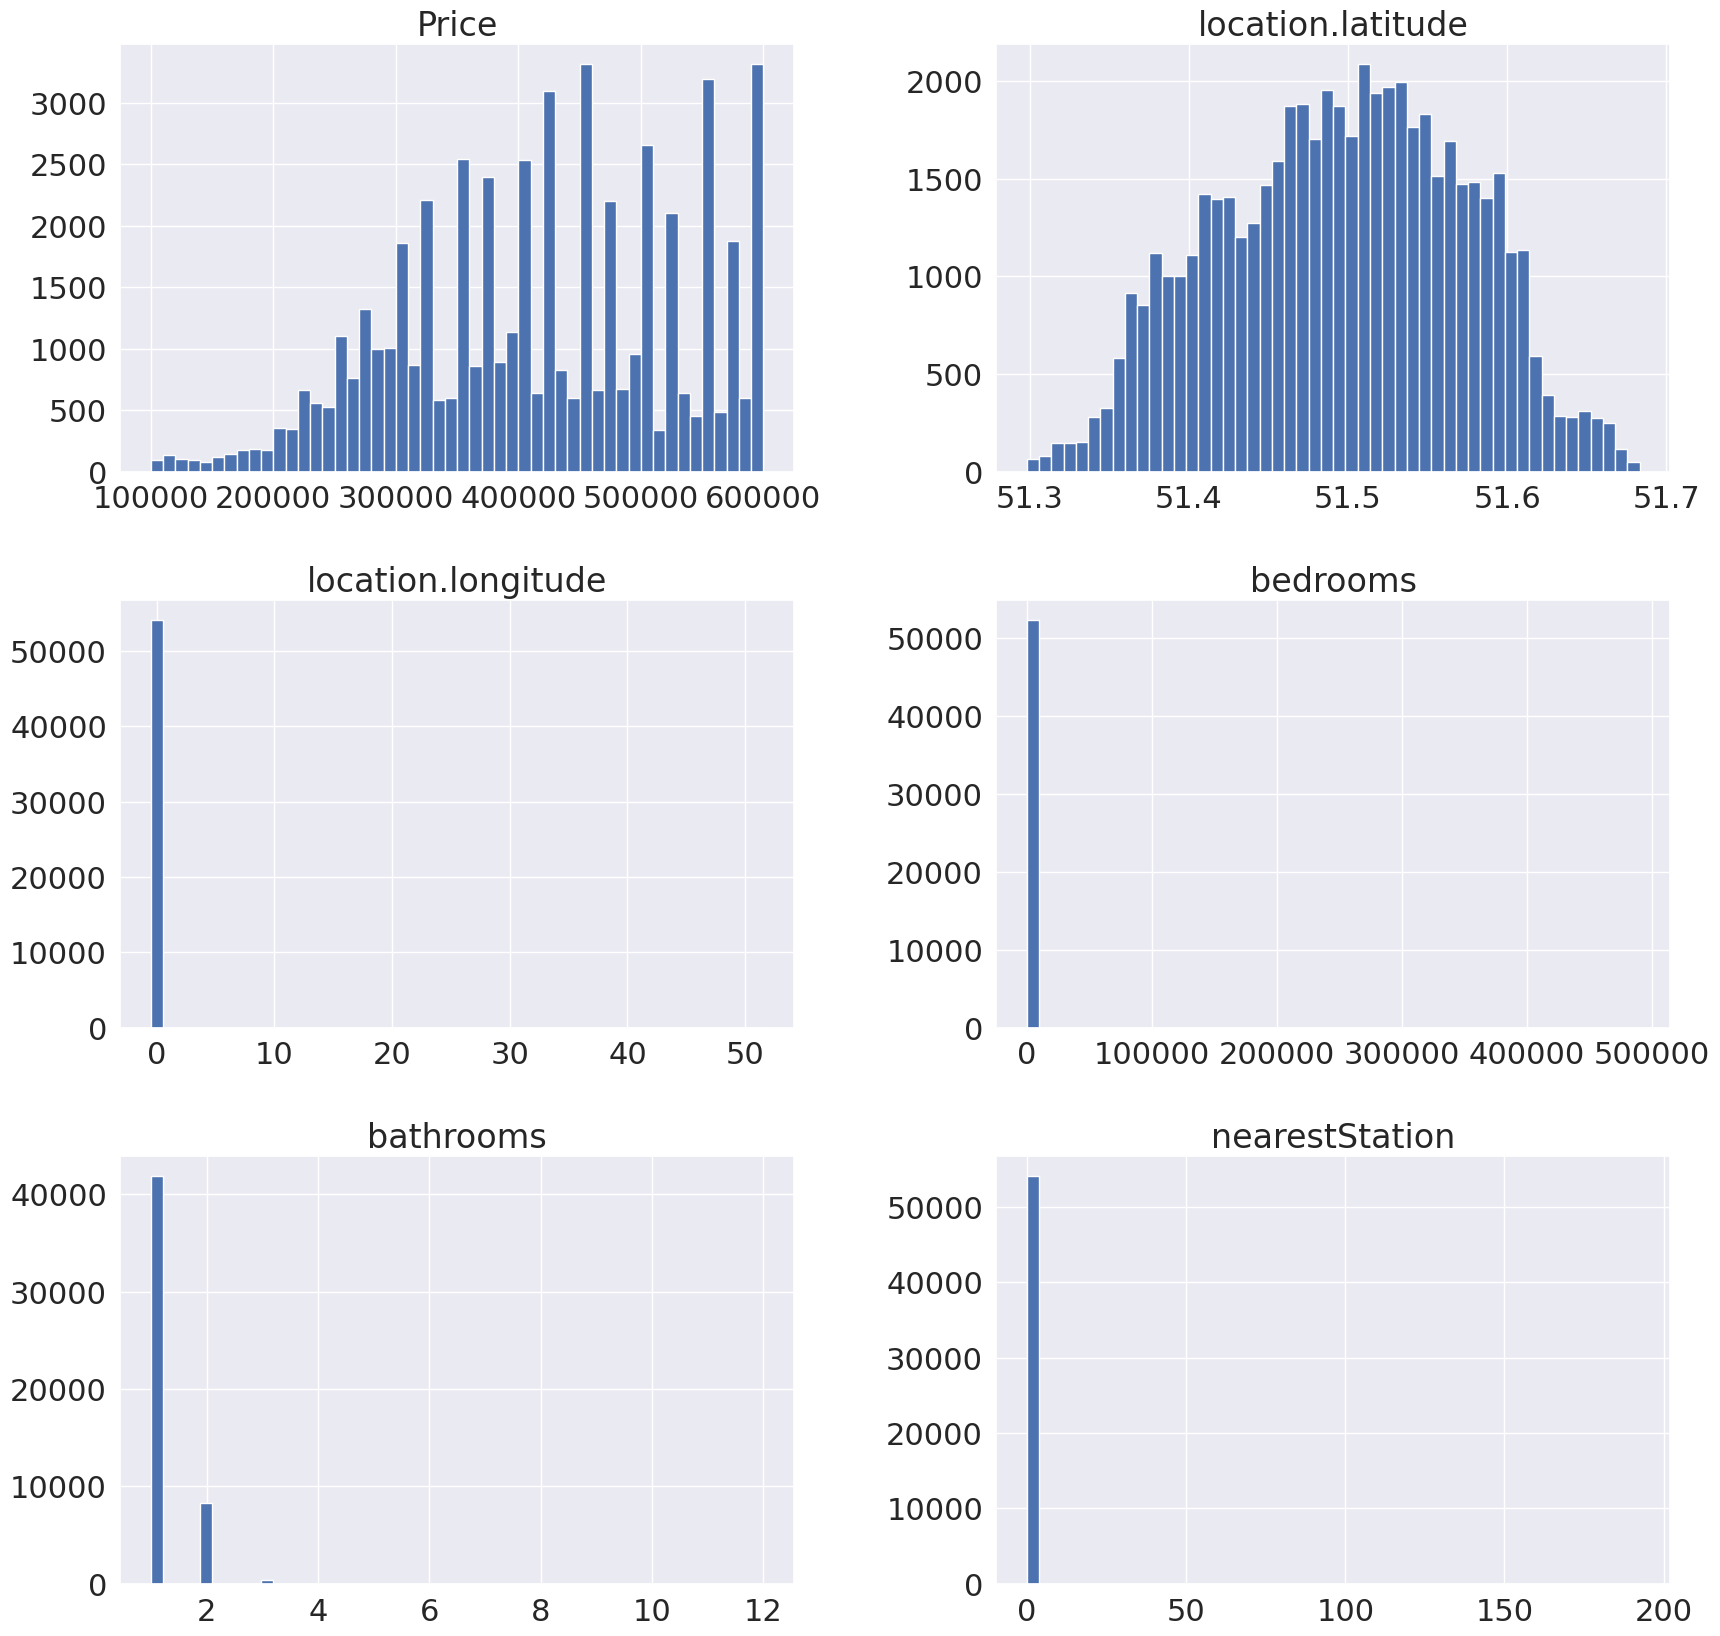

In [170]:
%matplotlib inline
df.hist(bins=50, figsize=(20, 20))
plt.show()

In [171]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,54067.0,416448.380528,113505.624206,100000.000000,325000.000000,425000.000000,500000.000000,600000.000000
location.latitude,54057.0,51.496130,0.076650,51.298317,51.439070,51.499478,51.554067,51.683185
location.longitude,54067.0,-0.106239,0.718769,-0.498315,-0.212965,-0.105220,-0.012998,51.558746
bedrooms,52265.0,11.360145,2143.329175,1.000000,1.000000,2.000000,2.000000,490000.000000
bathrooms,50569.0,1.181534,0.413244,1.000000,1.000000,1.000000,1.000000,12.000000
nearestStation,54067.0,0.442075,1.049040,0.000000,0.221778,0.361208,0.553963,192.431869


<div id = 3 style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#b08888;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
              color:white;
          text-align:center;
          margin:0 auto;
          ">
    IDENTIFY OUTLIERS


</h2>
</div>

In [172]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['bedrooms'] > 5].sort_values('bedrooms',ascending=False)

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
125513798,490000.0,51.580290,-0.340270,490000.0,2.0,0.150384,LEASEHOLD
125880485,600000.0,51.440830,-0.038410,7.0,5.0,0.592204,FREEHOLD
125543333,550000.0,51.594000,0.160060,7.0,NaN,1.642956,FREEHOLD
119217689,525000.0,51.538560,0.118210,7.0,2.0,0.393151,FREEHOLD
124019570,600000.0,51.529453,0.184820,7.0,2.0,0.909304,FREEHOLD
84063621,600000.0,51.662239,-0.035894,6.0,2.0,0.525190,FREEHOLD
123811142,600000.0,51.474324,0.131402,6.0,1.0,0.758594,FREEHOLD
125568515,575000.0,51.527980,-0.461629,6.0,3.0,1.334739,FREEHOLD
125047877,525000.0,51.659081,-0.042710,6.0,3.0,0.592597,FREEHOLD
125000246,525000.0,51.489867,0.055150,6.0,2.0,0.118946,FREEHOLD


In [173]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['bedrooms'] > 10].sort_values('bedrooms',ascending=False)

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
125513798,490000.0,51.58029,-0.34027,490000.0,2.0,0.150384,LEASEHOLD


In [174]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['bathrooms'] > 5]

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
122875514,485000.0,51.400012,-0.062682,3.0,12.0,0.095729,FREEHOLD
123034523,365000.0,51.511447,0.012305,1.0,11.0,0.242776,NaN


In [175]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['location.longitude'] > 10]

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
117726977,250000.0,NaN,51.416213,NaN,NaN,0.204070,LEASEHOLD
118737587,600000.0,NaN,51.476357,4.0,2.0,0.559261,FREEHOLD
119410649,280000.0,NaN,51.558746,2.0,2.0,0.060633,LEASEHOLD
120572951,300000.0,NaN,51.400795,NaN,1.0,0.403894,FREEHOLD
121441124,300000.0,NaN,51.521018,NaN,NaN,0.141185,LEASEHOLD
122251739,400000.0,NaN,51.467950,3.0,2.0,0.352386,FREEHOLD
123704549,395000.0,NaN,51.470790,4.0,2.0,0.499003,FREEHOLD
124725866,395000.0,NaN,51.419006,NaN,NaN,0.346325,FREEHOLD
124725887,400000.0,NaN,51.475860,NaN,NaN,0.392091,FREEHOLD
124900562,220000.0,NaN,51.537886,NaN,NaN,0.549313,FREEHOLD


In [176]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['nearestStation'] > 20]

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
105719081,224995.0,51.457055,-0.131578,3.0,2.0,192.431869,FREEHOLD
117858356,285000.0,51.461170,0.149245,2.0,NaN,40.309392,FREEHOLD
122768234,270000.0,51.427000,0.019000,3.0,2.0,119.325844,FREEHOLD


In [177]:
df = df[(df['location.longitude'] <= 10)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"{old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

54067 ==> 49016


,count,mean,std,min,25%,50%,75%,max
Price,49016.0,421205.709136,110831.099938,100000.000000,339950.000000,425000.000000,500000.000000,600000.000000
location.latitude,49016.0,51.496432,0.077345,51.298317,51.438138,51.499720,51.555650,51.683185
location.longitude,49016.0,-0.114267,0.156269,-0.498315,-0.211373,-0.103357,-0.011796,0.279726
bedrooms,49016.0,1.981394,0.824532,1.000000,1.000000,2.000000,2.000000,7.000000
bathrooms,49016.0,1.186674,0.413086,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,49016.0,0.437429,0.353326,0.000000,0.224506,0.365045,0.556585,16.168861


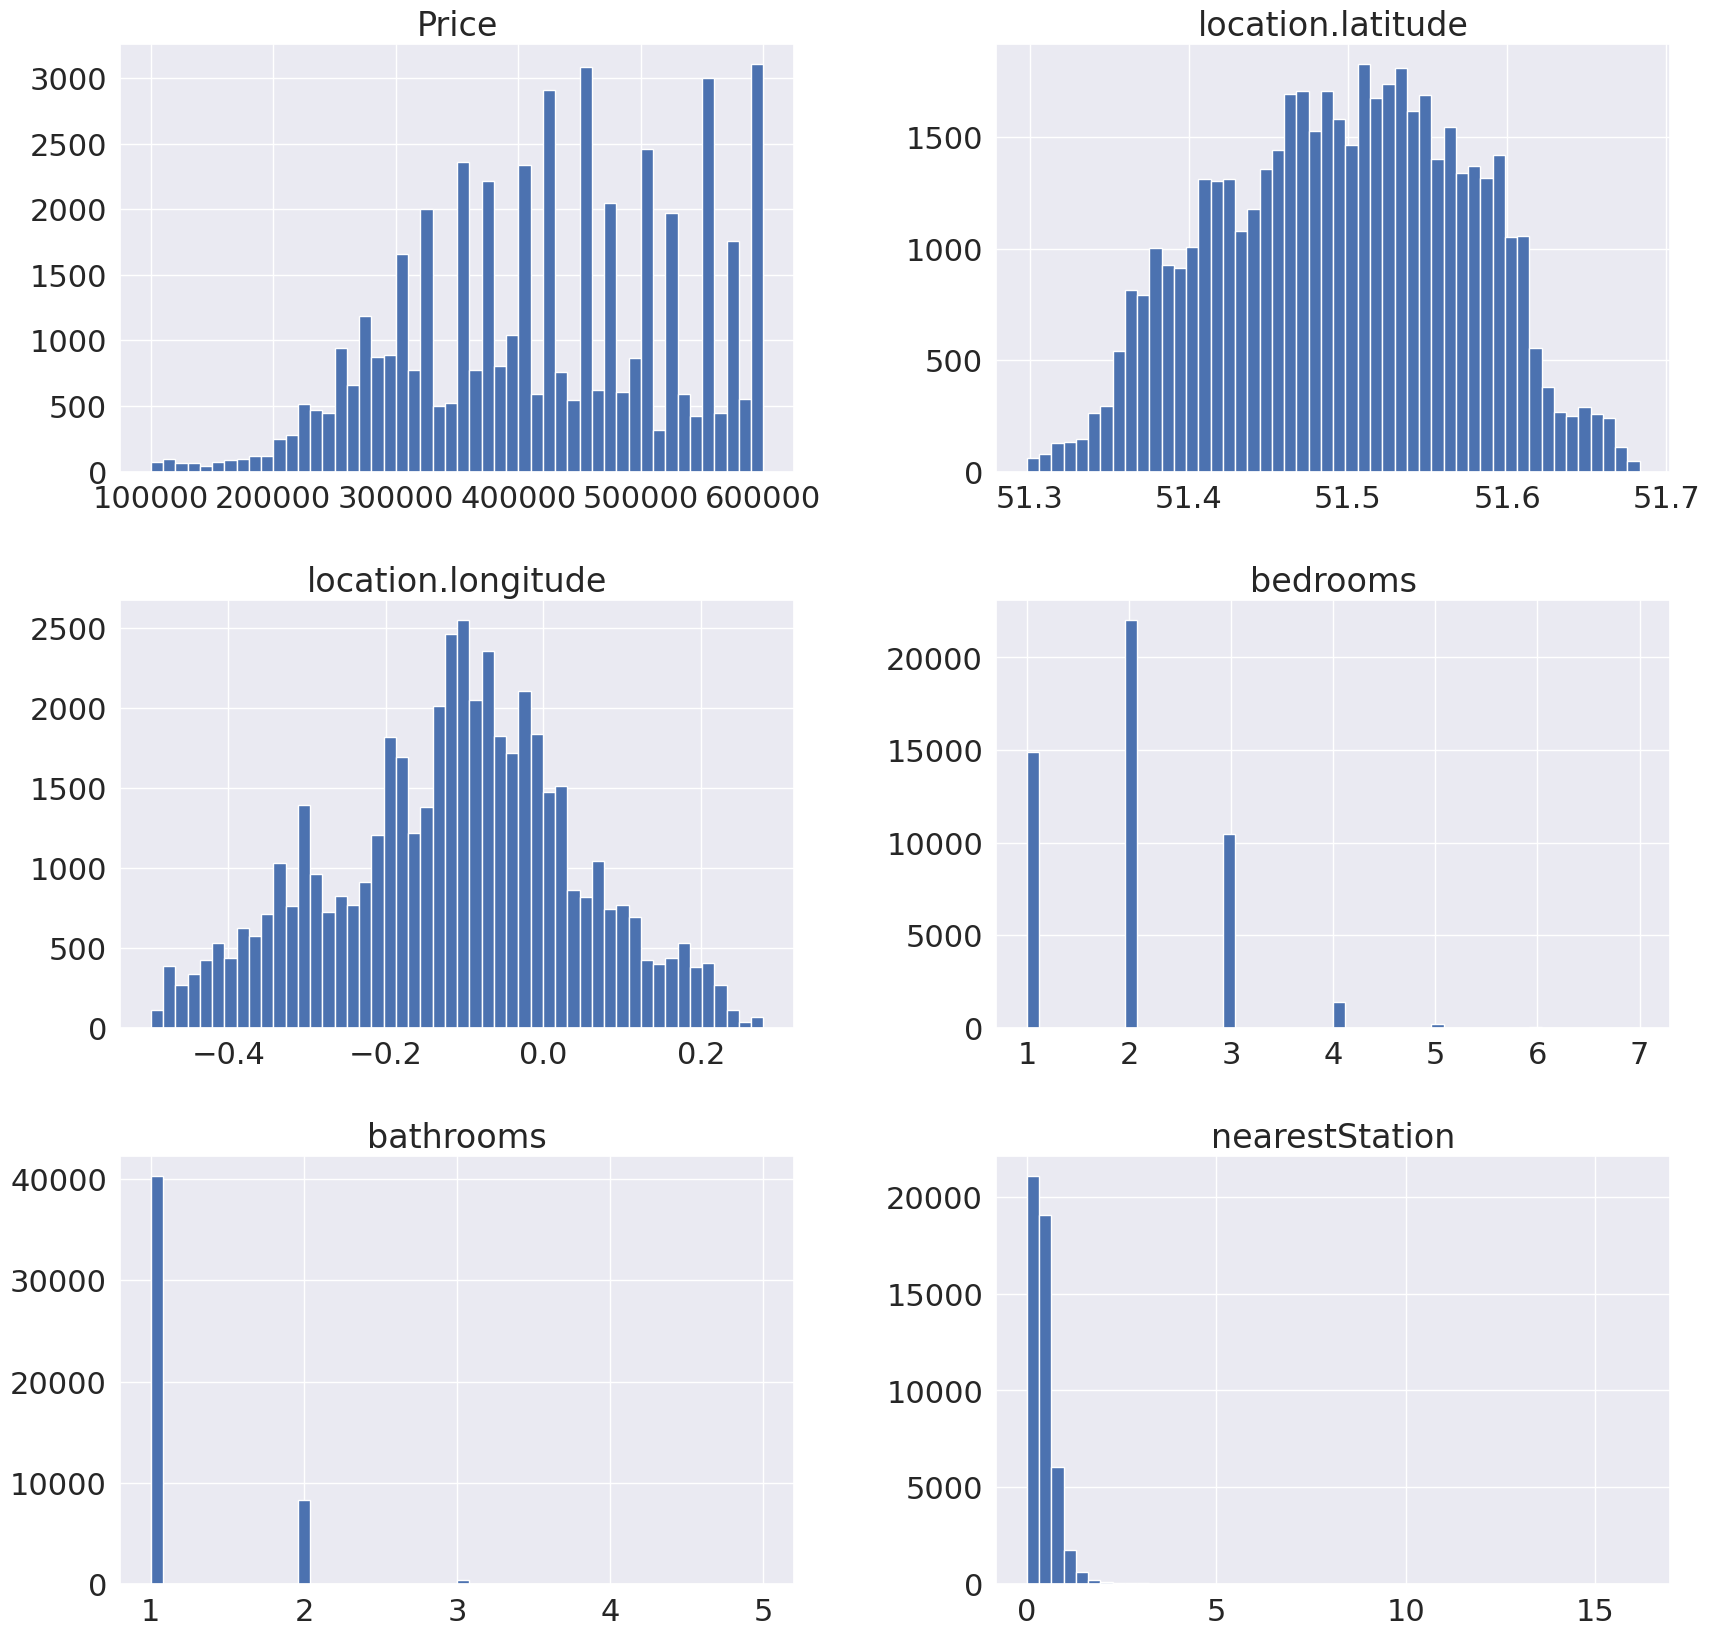

In [178]:
df.hist(bins=50, figsize=(20, 20))
plt.show()

In [179]:
df.isna().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms                 0
bathrooms                0
nearestStation           0
tenure.tenureType     2874
dtype: int64

In [180]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

49016 ==> 46142


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation
count,46142.000000,46142.000000,46142.000000,46142.000000,46142.000000,46142.000000
mean,421282.384335,51.496075,-0.114033,1.979953,1.185753,0.437174
std,110858.107656,0.077508,0.155650,0.823314,0.411915,0.352397
min,100000.000000,51.298317,-0.498315,1.000000,1.000000,0.000000
25%,339950.000000,51.437568,-0.211290,1.000000,1.000000,0.225159
50%,425000.000000,51.498427,-0.103070,2.000000,1.000000,0.365437
75%,500000.000000,51.555687,-0.012061,2.000000,1.000000,0.556509
max,600000.000000,51.683185,0.279726,7.000000,5.000000,16.168861


In [181]:
df_features = df.drop(LABEL, axis=1)
df_features

,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
14520525,51.529950,-0.207020,3.0,1.0,0.274316,LEASEHOLD
27953107,51.549390,-0.482600,2.0,2.0,0.305845,LEASEHOLD
33593487,51.447180,-0.338770,2.0,1.0,0.438045,FREEHOLD
35271294,51.449568,-0.140154,2.0,1.0,0.399307,LEASEHOLD
44749111,51.370050,-0.212410,2.0,1.0,0.410550,FREEHOLD
...,...,...,...,...,...,...
126179018,51.370651,-0.238346,2.0,1.0,0.682879,FREEHOLD
126179672,51.357170,-0.074740,3.0,2.0,0.545665,LEASEHOLD
126180107,51.531415,-0.052964,2.0,1.0,0.191407,LEASEHOLD
126180704,51.543141,0.011498,2.0,1.0,0.308609,LEASEHOLD


In [182]:
for column in categories:
    df_features = pd.concat([df_features, pd.get_dummies(df_features[column], prefix=column)], axis=1)
    df_features.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

features_corr = df_features.corr()
features_corr

,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType_COMMONHOLD,tenure.tenureType_FREEHOLD,tenure.tenureType_LEASEHOLD,tenure.tenureType_SHARE_OF_FREEHOLD
location.latitude,1.000000,0.095506,0.003520,-0.004468,0.026540,0.001639,0.002635,0.025084,-0.041335
location.longitude,0.095506,1.000000,0.119280,0.017276,0.038873,0.005302,0.138167,-0.070736,-0.081684
bedrooms,0.003520,0.119280,1.000000,0.330318,0.219620,-0.003975,0.591644,-0.459230,-0.113850
bathrooms,-0.004468,0.017276,0.330318,1.000000,0.045828,-0.005555,0.083191,-0.035804,-0.059046
nearestStation,0.026540,0.038873,0.219620,0.045828,1.000000,-0.003568,0.281375,-0.202475,-0.078011
tenure.tenureType_COMMONHOLD,0.001639,0.005302,-0.003975,-0.005555,-0.003568,1.000000,-0.007299,-0.015796,-0.004507
tenure.tenureType_FREEHOLD,0.002635,0.138167,0.591644,0.083191,0.281375,-0.007299,1.000000,-0.759929,-0.216845
tenure.tenureType_LEASEHOLD,0.025084,-0.070736,-0.459230,-0.035804,-0.202475,-0.015796,-0.759929,1.000000,-0.469268
tenure.tenureType_SHARE_OF_FREEHOLD,-0.041335,-0.081684,-0.113850,-0.059046,-0.078011,-0.004507,-0.216845,-0.469268,1.000000


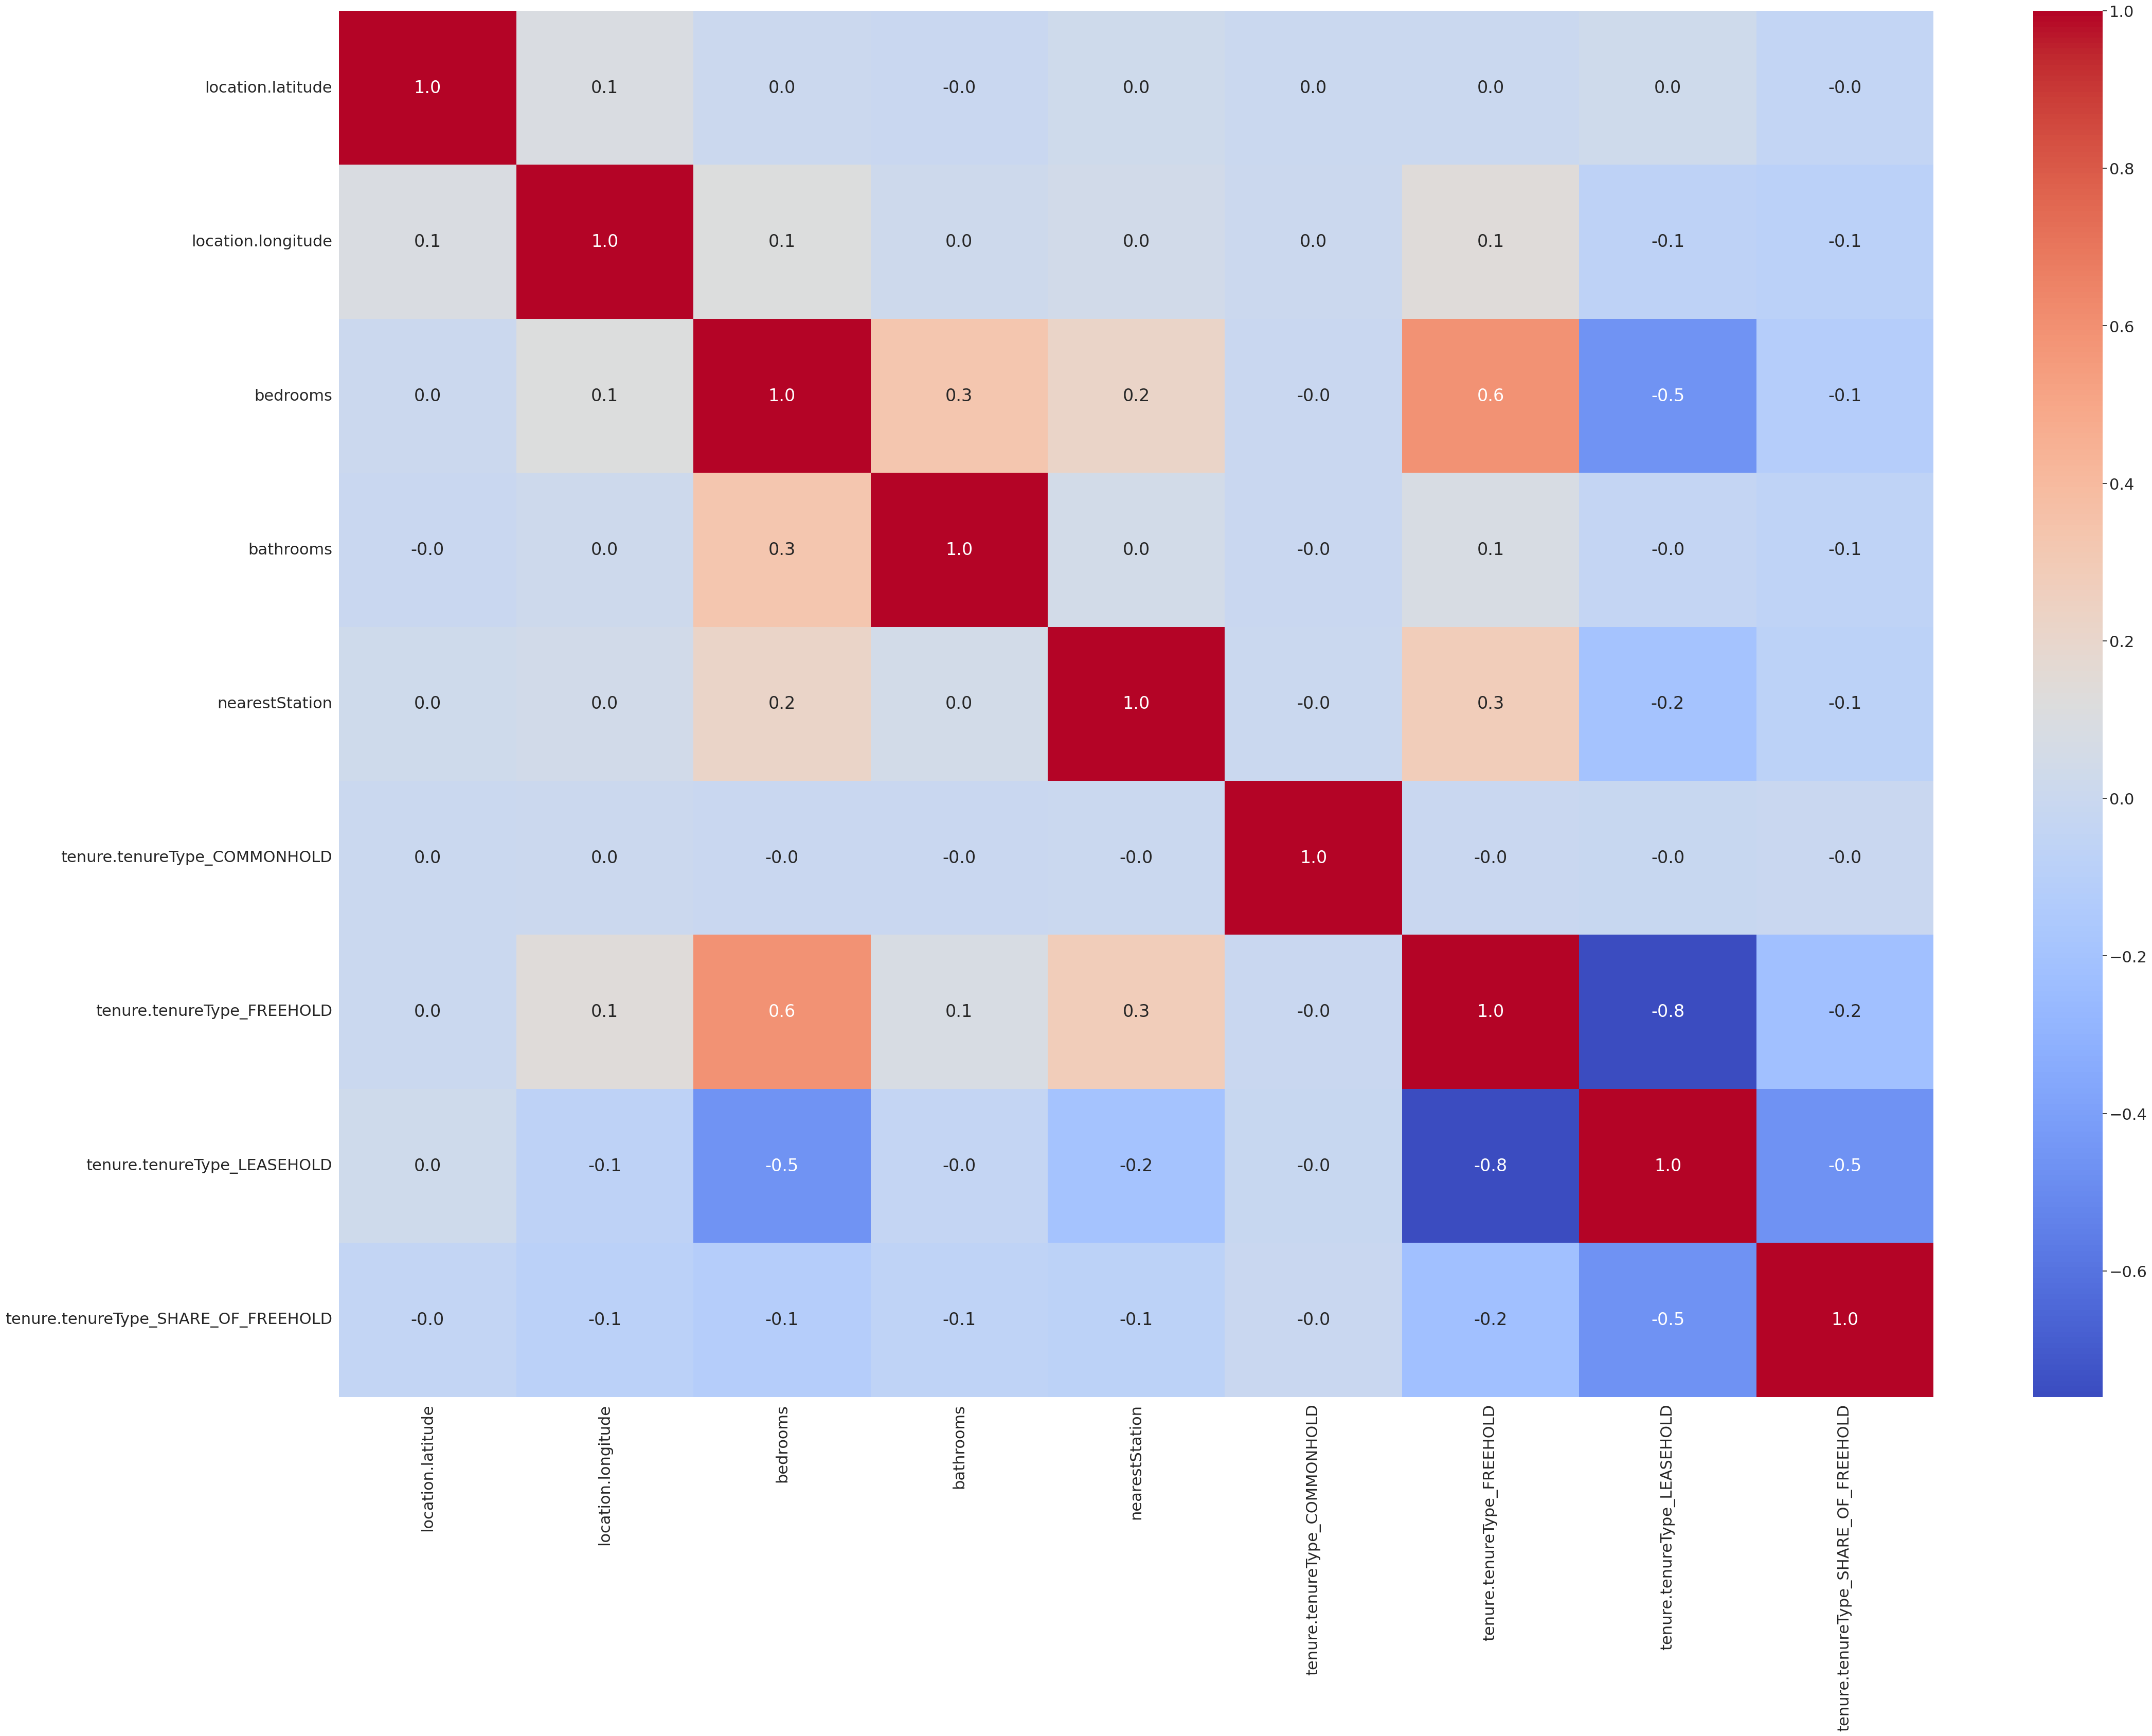

In [183]:
sns.set(font_scale=2)
plt.figure(figsize=(50, 35))
ax = sns.heatmap(features_corr, annot=True, fmt='.1f', cmap='coolwarm')

In [188]:
data_corr = df.corr()
data_corr_dict = data_corr["Price"].sort_values(ascending=False).to_dict()
data_corr_dict

{'Price': 1.0,
 'bedrooms': 0.46527085641940874,
 'bathrooms': 0.2529910132814157,
 'location.latitude': 0.053816413219107094,
 'nearestStation': -0.014052633745796133,
 'location.longitude': -0.0635398802054931}

In [189]:
#print the most positively correlated features
pos_corr = {k: v for k, v in data_corr_dict.items() if v > 0.1 and v != 1}
pos_corr

{'bedrooms': 0.46527085641940874, 'bathrooms': 0.2529910132814157}

In [190]:
#print the most negatively correlated features
neg_corr = {k: v for k, v in data_corr_dict.items() if v < -0.1}
neg_corr

{}

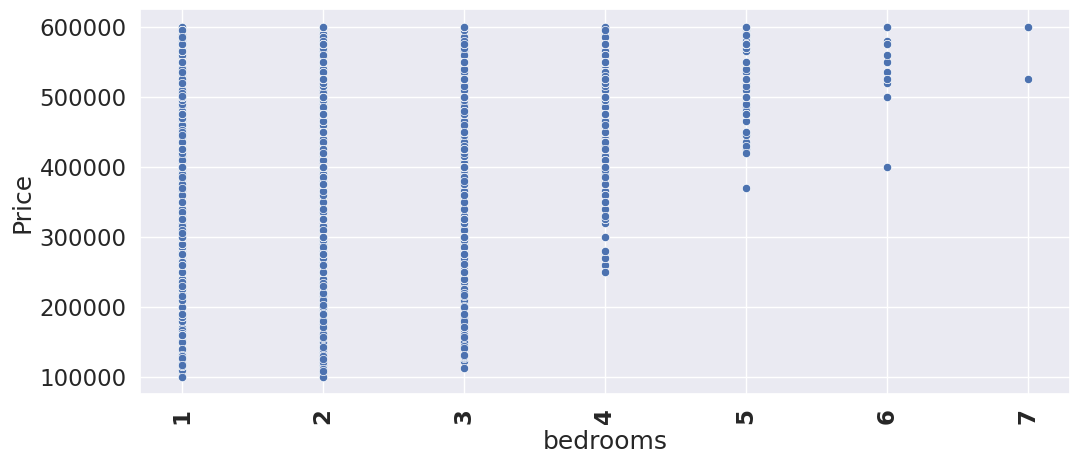

In [193]:
plt.figure(figsize=(12, 5))
sns.set(font_scale=1.5)
sns.scatterplot(x='bedrooms', y='Price', data=df)
plt.xticks(weight='bold', rotation=90)
plt.show()